In [157]:
from builtins import sorted
import ffmpeg
import librosa
import librosa.display
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re
import os
import sys
import shutil
import pandas as pd
from tabulate import tabulate
import mir_eval
import csv

import warnings
warnings.filterwarnings('ignore') #for reading mp3

#librosa==0.7.2
#numba==0.43

In [158]:
genres_list = ['disco', 'reggae', 'pop', 'rock',
               'metal', 'jazz', 'blues', 'hiphop', 'country']

template_types = ['binary', 'ks', 'harmonic']
chroma_operations = ['stft', 'cqt', 'cens']

binary_correct_accumulate_dict = {'disco': 0, 'reggae': 0, 'pop': 0, 'rock': 0,
                                  'metal': 0, 'jazz': 0, 'blues': 0, 'hiphop': 0, 'country': 0}

binary_file_num_dict = {'disco': 0, 'reggae': 0, 'pop': 0, 'rock': 0,
                        'metal': 0, 'jazz': 0, 'blues': 0, 'hiphop': 0, 'country': 0}

moving_scale = {0: '15', 1: '16', 2: '17', 3: '18', 4: '19', 5: '20',
                6: '21', 7: '22', 8: '23', 9: '0', 10: '1', 11: '2',
                12: '3', 13: '4', 14: '5', 15: '6', 16: '7', 17: '8',
                18: '9', 19: '10', 20: '11', 21: '12', 22: '13', 23: '14',
                }

annotation_scale = {0:'A', 1:'A#', 2:'B', 3:'C', 4:'C#',5:'D',
                    6:'D#', 7:'E', 8:'F', 9:'F#', 10:'G', 11:'G#',
                    12:'A', 13:'A#', 14:'B', 15:'C', 16:'C#', 17:'D',
                    18:'D#', 19:'E', 20:'F', 21:'F#', 22:'G', 23:'G#'}


annotation_major_scale = {'A':0, 'A#':1, 'Bb':1, 'B':2, 'C':3, 'C#':4, 'Db':4,'D':5,
                          'D#':6, 'Eb':6, 'E':7, 'F':8, 'F#':9, 'Gb':9, 'G':10, 'G#':11, 'Ab':11}

annotation_minor_scale = {'a':12, 'a#':13, 'bb':13, 'b':14, 'c':15, 'c#':16, 'db':16, 'd':17,
                          'd#':18, 'eb':18, 'e':19, 'f':20, 'f#':21, 'gb':21, 'g':22, 'g#':23, 'ab':23}

octave_scale = ['C', 'C#', 'D', 'D#', 'E', 'F',
                'F#', 'G', 'G#', 'A', 'A#', 'B']

recording_version = ['HU33', 'SC06', 'FI66', 'FI80']
file_type = ['HU33', 'SC06', 'FI66', 'FI80', 'midi']
audio_file_format = {"HU33":".wav", "SC06":".wav", "FI66":".mp3", "FI80":".mp3", "midi":".mid"}


In [159]:
# -- 1) binary-valued template matching
# -- 2) K-S template matching
# -- 3) harmonic template matching (try 𝛼 = 0.9).
# -- Using Cicular Shifting to generate another tone

binary_C_major = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
binary_C_minor = [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]

# -- C, C#, D, D#, E, F, F#, G, G#, A, A#, B
KS_C_major = [6.35, 2.23, 3.48, 2.33, 4.38,
              4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
KS_C_minor = [6.33, 2.68, 3.52, 5.38, 2.60,
              3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

binary_templates = [binary_C_major, binary_C_minor]
ks_templates = [KS_C_major, KS_C_minor]

alpha = 0.9

# C Major harmonic template
C_major_harmonic_template = [1 + alpha + alpha**3 + alpha**7, 0, 0, 0, alpha**4, 0,
                             0, alpha**2+alpha**5, 0, 0, alpha**6, 0]

all_pitches_harmonic_template = [0] * 12

# Get all pitchs harmonic template
for i in range(12):
    all_pitches_harmonic_template[i] = np.roll(C_major_harmonic_template, i-3)

harmonic_major_template = [0] * 12
harmonic_minor_template = [0] * 12

for i in range(12):
    if binary_templates[0][i] == 1:
        harmonic_major_template += all_pitches_harmonic_template[(i + 3) % 12]

for i in range(12):
    if binary_templates[1][i] == 1:
        harmonic_minor_template += all_pitches_harmonic_template[(i + 3) % 12]

harmonic_templates = [harmonic_major_template, harmonic_minor_template]

templates = {'binary':binary_templates, 'ks':ks_templates, 'harmonic':harmonic_templates}

In [160]:
# local key 調式標記
ann_audio_localkey_dict = {}
for format in recording_version:
    ann_audio_localkey_dict[format] = {}
    for i in range(1, 25):
        ann_audio_localkey_df = pd.read_csv("./HW1 Datasets/SWD/SWD/02_Annotations/ann_audio_localkey-ann1/Schubert_D911-" + str(i).zfill(2) + '_' + format + ".csv", sep=';')
        #print(ann_audio_localkey_df)
        ann_audio_localkey_dict[format][i] = ann_audio_localkey_df

# print(ann_audio_localkey_dict)

In [161]:
def replace_key(row):
    if (row.find('maj') != -1):
        return annotation_major_scale[row.split(':')[0]]
    elif (row.find('min') != -1):
        return annotation_minor_scale[row.split(':')[0].lower()]

In [162]:
for format in recording_version:
    for i in range(1, 25):
        ann_audio_localkey_dict[format][i]['ann_key'] = ann_audio_localkey_dict[format][i]['key'].apply(replace_key)
# print(ann_audio_localkey_dict)

In [163]:
ann_audio_localkey_dict['HU33'][1]

,start,end,key,ann_key
0,1.26,31.68,C:min,15
1,31.68,40.56,D#:maj,6
2,40.56,49.00,G#:maj,11
3,49.00,98.92,C:min,15
4,98.92,107.80,D#:maj,6
5,107.80,116.24,G#:maj,11
6,116.24,147.86,C:min,15
7,147.86,166.52,C:min,15
8,166.52,175.44,D#:maj,6
9,175.44,184.00,G#:maj,11


In [164]:
# 小節與時間的對應表
time_bar_dict = {}

for i in range(1, 25):
    time_bar_dict_df = pd.read_csv( "./HW1 Datasets/time_per_measure_ann_score_localkey-ann1/time_per_measure_ann_score_localkey-ann1/Schubert_D911-" + str(i).zfill(2) + ".csv", sep=',')
    time_bar_dict[i] = time_bar_dict_df

# print(time_bar_dict)

In [165]:
time_bar_dict[1]

,Measure,Time
0,1.0,0.00
1,2.0,2.18
2,3.0,4.36
3,4.0,6.54
4,5.0,8.72
...,...,...
133,134.0,289.94
134,135.0,292.12
135,136.0,294.30
136,137.0,296.48


## 沿用 Q4 所產生的 prediction 檔案


In [166]:
def prediction_eval(mean_pool_range):
    segmentation_eval = {}

    analysis_path = "./temp/SWD_analysis_Q5/"
    try:
        shutil.rmtree(analysis_path)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))

    for format in file_type:
        segmentation_eval[format] = {}
        if format == 'midi':
            for song_no in range(1, 25):
                segmentation_eval[format][song_no] = {}
                for template_type in template_types:
                    prediction_save_path = "./temp/SWD_analysis_Q4/" + format + "/" + str(mean_pool_range) + "/" + str(song_no) + "/" + template_type + ".txt"
                    segmentation_eval[format][song_no][template_type] = {}
                    prediction_time_output = "./temp/SWD_analysis_Q5/" + format + "/" + str(mean_pool_range) + "/" + str(song_no) + "/" + template_type + ".csv"
                    
                    os.makedirs(os.path.dirname(prediction_time_output), exist_ok=True)
                    with open(prediction_time_output, 'w') as output_file:
                        output_writer = csv.writer(output_file, delimiter = ';', quotechar = "'", quoting = csv.QUOTE_MINIMAL)
                        output_writer.writerow(['start','end','key'])
                    
                    with open(prediction_save_path) as file_p:
                        lines = file_p.readlines()
                        count = 0
                        base_time = 0.0
                        prev_frame_key = 0
                        for line in lines:
                            if count == 0:
                                prev_frame_key = int(line.strip())
                                count += 1
                            else: 
                                frame_key = int(line.strip())
                                if frame_key == prev_frame_key:
                                    count += 1
                                else:
                                    with open(prediction_time_output, 'a') as output_file:
                                        output_writer = csv.writer(output_file, delimiter = ';', quotechar = "'", quoting = csv.QUOTE_MINIMAL)
                                        output_label = annotation_scale[frame_key]
                                        if frame_key < 12:
                                            output_label = output_label + ':maj'
                                        else:
                                            output_label = output_label + ':min'
                                        output_writer.writerow([round(base_time, 2), round(base_time + (count * 0.1), 2), '\"' + output_label + '\"'])
                                    prev_frame_key = frame_key
                                    base_time += count * 0.1
                                    count = 0
                        if count != 0:
                            with open(prediction_time_output, 'a') as output_file:
                                output_writer = csv.writer(output_file, delimiter = ';', quotechar = "'", quoting = csv.QUOTE_MINIMAL)
                                output_label = annotation_scale[frame_key]
                                if frame_key < 12:
                                    output_label = output_label + ':maj'
                                else:
                                    output_label = output_label + ':min'
                                output_writer.writerow([round(base_time, 2), round(base_time + (count * 0.1), 2), '\"' + output_label + '\"'])

                    intervals_prediction, labels_prediction = mir_eval.io.load_labeled_intervals(prediction_time_output, 
                                                                                    delimiter=';',
                                                                                    comment='start;end;key')
                    print(intervals_prediction)
                    intervals_answer, labels_answer = mir_eval.io.load_labeled_intervals('./HW1 Datasets/SWD/SWD/02_Annotations/ann_audio_localkey-ann1/Schubert_D911-' + str(song_no).zfill(2) + '_HU33.csv', 
                                                                                    delimiter=';',
                                                                                    comment='start;end;key')    
                    print(intervals_answer)
                    # Compute the MIREX ‘MeanSeg’ score.
                    #   Comparison score, in [0.0, 1.0], where 1.0 means perfect segmentation.
                    segmentation_eval[format][song_no][template_type]['MeanSeg'] = mir_eval.chord.seg(intervals_prediction, intervals_answer)
                    # Computes the level of over-segmentation
                    # over-segmentation score
                    #   Comparison score, in [0.0, 1.0], where 1.0 means no oversegmentation.
                    segmentation_eval[format][song_no][template_type]['OverSeg'] = mir_eval.chord.overseg(intervals_prediction, intervals_answer)
                    # Computes the level of under-segmentation
                    segmentation_eval[format][song_no][template_type]['UnderSeg'] = mir_eval.chord.underseg(intervals_prediction, intervals_answer) 
                    

        else:
            for song_no in range(1, 25):
                segmentation_eval[format][song_no] = {}
                for chroma_operation in chroma_operations:
                    segmentation_eval[format][song_no][chroma_operation] = {}
                    for template_type in template_types:
                        prediction_save_path = "./temp/SWD_analysis_Q4/" + format + "/" + str(mean_pool_range) + "/" + str(song_no) + "/" + chroma_operation + "/" + template_type + ".txt"
                        segmentation_eval[format][song_no][chroma_operation][template_type] = {}
                        prediction_time_output = "./temp/SWD_analysis_Q5/" + format + "/" + str(mean_pool_range) + "/" + str(song_no) + "/" + chroma_operation + "/" + template_type + ".csv"
                        
                        os.makedirs(os.path.dirname(prediction_time_output), exist_ok=True)
                        with open(prediction_time_output, 'w') as output_file:
                            output_writer = csv.writer(output_file, delimiter = ';', quotechar = "'", quoting = csv.QUOTE_MINIMAL)
                            output_writer.writerow(['start','end','key'])

                        with open(prediction_save_path) as file_p:
                            lines = file_p.readlines()
                            count = 0
                            base_time = 0.0
                            prev_frame_key = 0
                            for line in lines:
                                if count == 0:
                                    prev_frame_key = int(line.strip())
                                    count += 1
                                else: 
                                    frame_key = int(line.strip())
                                    if frame_key == prev_frame_key:
                                        count += 1
                                    else:
                                        with open(prediction_time_output, 'a') as output_file:
                                            output_writer = csv.writer(output_file, delimiter = ';', quotechar = "'", quoting = csv.QUOTE_MINIMAL)
                                            output_label = annotation_scale[frame_key]
                                            if frame_key < 12:
                                                output_label = output_label + ':maj'
                                            else:
                                                output_label = output_label + ':min'
                                            output_writer.writerow([round(base_time, 2), round(base_time + (count * 0.1), 2), '\"' + output_label + '\"'])
                                        prev_frame_key = frame_key
                                        base_time += count * 0.1
                                        count = 0
                            if count != 0:
                                with open(prediction_time_output, 'a') as output_file:
                                    output_writer = csv.writer(output_file, delimiter = ';', quotechar = "'", quoting = csv.QUOTE_MINIMAL)
                                    output_label = annotation_scale[frame_key]
                                    if frame_key < 12:
                                        output_label = output_label + ':maj'
                                    else:
                                        output_label = output_label + ':min'
                                    output_writer.writerow([round(base_time, 2), round(base_time + (count * 0.1), 2), '\"' + output_label + '\"'])

                        intervals_prediction, labels_prediction = mir_eval.io.load_labeled_intervals(prediction_time_output, 
                                                                                        delimiter=';',
                                                                                        comment='start;end;key')
                        print(intervals_prediction)
                        intervals_answer, labels_answer = mir_eval.io.load_labeled_intervals('./HW1 Datasets/SWD/SWD/02_Annotations/ann_audio_localkey-ann1/Schubert_D911-' + str(song_no).zfill(2) + '_' + format +'.csv', 
                                                                                        delimiter=';',
                                                                                        comment='start;end;key')    
                        print(intervals_answer)
                        # Compute the MIREX ‘MeanSeg’ score.
                        #   Comparison score, in [0.0, 1.0], where 1.0 means perfect segmentation.
                        segmentation_eval[format][song_no][chroma_operation][template_type]['MeanSeg'] = mir_eval.chord.seg(intervals_prediction, intervals_answer)
                        # Computes the level of over-segmentation
                        # over-segmentation score
                        #   Comparison score, in [0.0, 1.0], where 1.0 means no oversegmentation.
                        segmentation_eval[format][song_no][chroma_operation][template_type]['OverSeg'] = mir_eval.chord.overseg(intervals_prediction, intervals_answer)
                        # Computes the level of under-segmentation
                        #    Comparison score, in [0.0, 1.0], where 1.0 means no undersegmentation.
                        segmentation_eval[format][song_no][chroma_operation][template_type]['UnderSeg'] = mir_eval.chord.underseg(intervals_prediction, intervals_answer)
    return segmentation_eval

In [167]:
segmentation_eval = prediction_eval(300)

[[  0.   11.2]
 [ 11.2  12.7]
 [ 12.7  35.1]
 [ 35.1  42.5]
 [ 42.5  99.4]
 [ 99.4 100.7]
 [100.7 109.9]
 [109.9 166.8]
 [166.8 168.6]
 [168.6 177.3]
 [177.3 205.9]
 [205.9 208.8]
 [208.8 209.6]
 [209.6 228.3]
 [228.3 240.8]
 [240.8 240.9]
 [240.9 241.1]
 [241.1 241.6]
 [241.6 247.4]
 [247.4 249.9]
 [249.9 309.7]]
[[  1.26  31.68]
 [ 31.68  40.56]
 [ 40.56  49.  ]
 [ 49.    98.92]
 [ 98.92 107.8 ]
 [107.8  116.24]
 [116.24 147.86]
 [147.86 166.52]
 [166.52 175.44]
 [175.44 184.  ]
 [184.   217.16]
 [217.16 239.62]
 [239.62 250.  ]
 [250.   283.28]
 [283.28 305.68]]
[[  0.   19.7]
 [ 19.7  35.2]
 [ 35.2  42.6]
 [ 42.6  56.4]
 [ 56.4  86.4]
 [ 86.4  99.3]
 [ 99.3 100.6]
 [100.6 109.8]
 [109.8 122.6]
 [122.6 156.1]
 [156.1 166.5]
 [166.5 168.3]
 [168.3 177. ]
 [177.  182.1]
 [182.1 247.8]
 [247.8 250.3]
 [250.3 310.1]]
[[  1.26  31.68]
 [ 31.68  40.56]
 [ 40.56  49.  ]
 [ 49.    98.92]
 [ 98.92 107.8 ]
 [107.8  116.24]
 [116.24 147.86]
 [147.86 166.52]
 [166.52 175.44]
 [175.44 184.  ]
 [

## Segmentation 評分
### MeanSeg 分數：
    分數範圍落在 [0.0, 1.0] 區間，而 1.0 代表 perfect segmentation（完美分割），數值越高越好。

### OverSeg 分數：
    分數範圍落在 [0.0, 1.0] 區間，而 1.0 代表沒有 oversegmentation (過度分割)，數值越高越好。

### UnderSeg 分數：
    分數範圍落在 [0.0, 1.0] 區間，而 1.0 代表沒有 undersegmentation (缺乏分割)，數值越高越好。


以 30s 作為 mean pooling 區間，透過下面的直方圖可以看到不論哪個種類的錄音/midi 的完美切割率大概在 55% 左右。而 OverSeg 高於 UnderSeg 分數，代表缺乏分割的程度較高，或許隱含以 30s 為取均值的區間有點太長。

In [168]:
# --- 40s
segmentation_eval_midi = {"midi":segmentation_eval['midi']}
# print(prediction_midi)

segmentation_eval_without_midi = segmentation_eval
del segmentation_eval_without_midi['midi']

In [169]:
segmentation_eval_without_midi_df = pd.DataFrame.from_dict({(i, j, k, m): segmentation_eval_without_midi[i][j][k][m]
                            for i in segmentation_eval_without_midi.keys()
                            for j in segmentation_eval_without_midi[i].keys()
                            for k in segmentation_eval_without_midi[i][j].keys()
                            for m in segmentation_eval_without_midi[i][j][k].keys()
                            }, orient='columns').T

segmentation_eval_without_midi_df.reset_index(inplace=True)
segmentation_eval_without_midi_df.columns = ['format', 'song_no', 'chroma_operation','template_type', 'MeanSeg', 'OverSeg', 'UnderSeg']

In [170]:
segmentation_eval_midi_df = pd.DataFrame.from_dict({(i, j, k): segmentation_eval_midi[i][j][k]
                            for i in segmentation_eval_midi.keys()
                            for j in segmentation_eval_midi[i].keys()
                            for k in segmentation_eval_midi[i][j].keys()
                            }, orient='columns').T

segmentation_eval_midi_df.reset_index(inplace=True)
segmentation_eval_midi_df.columns = ['format', 'song_no','template_type', 'MeanSeg', 'OverSeg', 'UnderSeg']

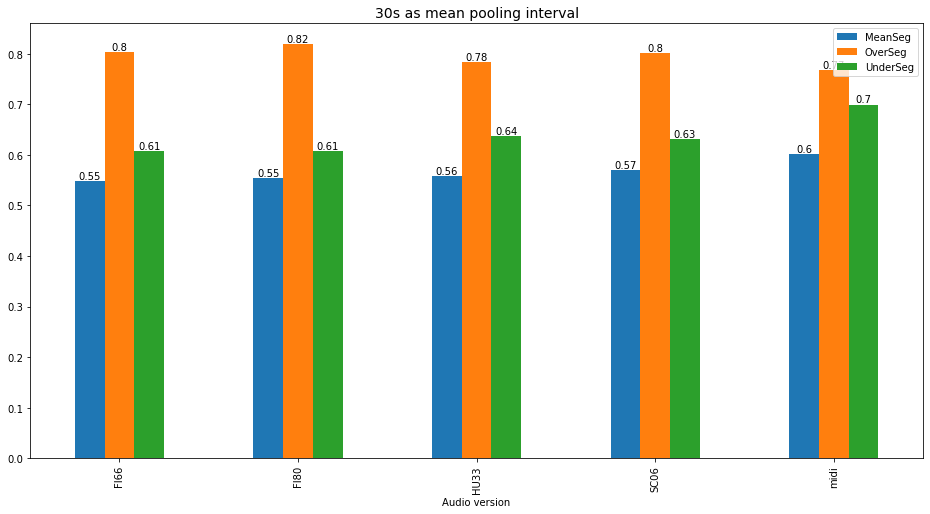

In [171]:
group_by_format = segmentation_eval_without_midi_df.groupby("format")
group_by_format_midi = segmentation_eval_midi_df.groupby("format")
concat_item = [group_by_format.mean(), group_by_format_midi.mean()]
result_group_by_format = pd.concat(concat_item)

ax = result_group_by_format[['MeanSeg', 'OverSeg', 'UnderSeg']].plot(kind='bar', figsize=(16, 8))
ax.set_title('30s as mean pooling interval', fontsize = 14)

for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    ax.set_xlabel('Audio version')

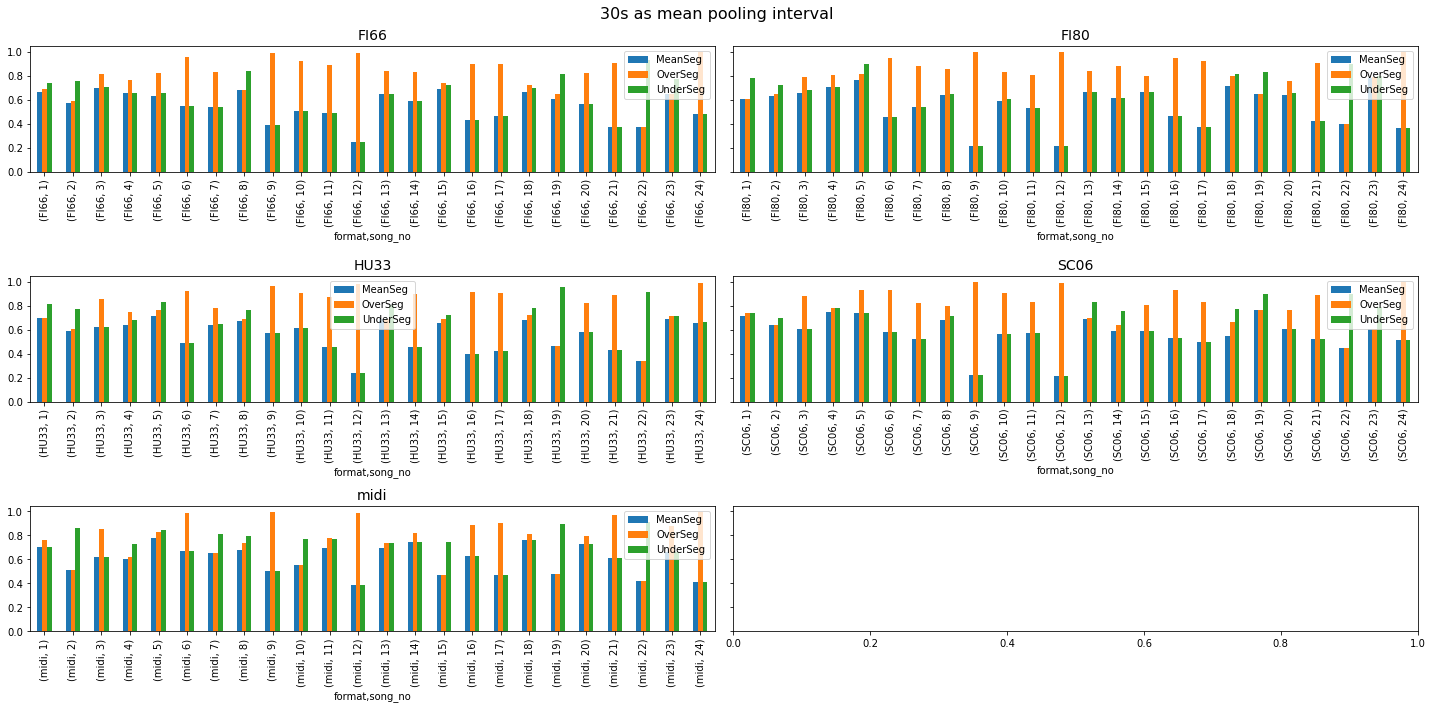

In [172]:
group_by_song = segmentation_eval_without_midi_df.groupby(["format", "song_no"])
group_by_song_midi = segmentation_eval_midi_df.groupby(["format", "song_no"])
concat_item_song = [group_by_song.mean(), group_by_song_midi.mean()]
result_group_by_song = pd.concat(concat_item_song)

result_group_by_format = result_group_by_song.groupby("format")
ncols=2
nrows = int(np.ceil(result_group_by_format.ngroups/ncols))

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,10), sharey = True)
fig.suptitle('30s as mean pooling interval', fontsize=16)

for (key, ax) in zip(result_group_by_format.groups.keys(), axes.flatten()):
    ax.set_title(key, fontsize = 14)
    result_group_by_format.get_group(key).plot(ax = ax, kind = 'bar')

ax.legend()
fig.tight_layout()
plt.show()

# ax_song = result_group_by_song[['MeanSeg', 'OverSeg', 'UnderSeg']].plot(kind='bar', figsize=(32, 8))
# ax_song.set_title('30s as mean pooling interval', fontsize = 14)

# for bar_plot in ax_song.patches:
#     ax_song.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
#                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')
#     ax_song.set_xlabel('Audio version')

## 不同 Mean pool range

In [173]:
segmentation_eval_200 = prediction_eval(200)

[[  0.   33.4]
 [ 33.4  34.8]
 [ 34.8  35.8]
 [ 35.8  36.5]
 [ 36.5  36.6]
 [ 36.6  47.8]
 [ 47.8  99.5]
 [ 99.5 102.3]
 [102.3 103.2]
 [103.2 103.6]
 [103.6 114.5]
 [114.5 164.4]
 [164.4 165.1]
 [165.1 171.2]
 [171.2 181.7]
 [181.7 207.2]
 [207.2 227.4]
 [227.4 228.3]
 [228.3 228.8]
 [228.8 229.4]
 [229.4 232.2]
 [232.2 233.9]
 [233.9 237.1]
 [237.1 238.3]
 [238.3 244.8]
 [244.8 246.7]
 [246.7 246.9]
 [246.9 247. ]
 [247.  249.6]
 [249.6 249.9]
 [249.9 251. ]
 [251.  254.9]
 [254.9 308.5]]
[[  1.26  31.68]
 [ 31.68  40.56]
 [ 40.56  49.  ]
 [ 49.    98.92]
 [ 98.92 107.8 ]
 [107.8  116.24]
 [116.24 147.86]
 [147.86 166.52]
 [166.52 175.44]
 [175.44 184.  ]
 [184.   217.16]
 [217.16 239.62]
 [239.62 250.  ]
 [250.   283.28]
 [283.28 305.68]]
[[  0.   23.1]
 [ 23.1  33.3]
 [ 33.3  34.7]
 [ 34.7  35.7]
 [ 35.7  36.4]
 [ 36.4  36.5]
 [ 36.5  47.7]
 [ 47.7  52.8]
 [ 52.8  89.6]
 [ 89.6  99.2]
 [ 99.2 102. ]
 [102.  102.9]
 [102.9 103.3]
 [103.3 114.2]
 [114.2 117.8]
 [117.8 118.6]
 [118.6 

In [174]:
# --- 10s
segmentation_eval_midi_200 = {"midi":segmentation_eval_200['midi']}
# print(prediction_midi)

segmentation_eval_without_midi_200 = segmentation_eval_200
del segmentation_eval_without_midi_200['midi']

In [175]:
segmentation_eval_without_midi_df_200 = pd.DataFrame.from_dict({(i, j, k, m): segmentation_eval_without_midi_200[i][j][k][m]
                            for i in segmentation_eval_without_midi_200.keys()
                            for j in segmentation_eval_without_midi_200[i].keys()
                            for k in segmentation_eval_without_midi_200[i][j].keys()
                            for m in segmentation_eval_without_midi_200[i][j][k].keys()
                            }, orient='columns').T

segmentation_eval_without_midi_df_200.reset_index(inplace=True)
segmentation_eval_without_midi_df_200.columns = ['format', 'song_no', 'chroma_operation','template_type', 'MeanSeg', 'OverSeg', 'UnderSeg']

In [176]:
segmentation_eval_midi_df_200 = pd.DataFrame.from_dict({(i, j, k): segmentation_eval_midi_200[i][j][k]
                            for i in segmentation_eval_midi_200.keys()
                            for j in segmentation_eval_midi_200[i].keys()
                            for k in segmentation_eval_midi_200[i][j].keys()
                            }, orient='columns').T

segmentation_eval_midi_df_200.reset_index(inplace=True)
segmentation_eval_midi_df_200.columns = ['format', 'song_no','template_type', 'MeanSeg', 'OverSeg', 'UnderSeg']

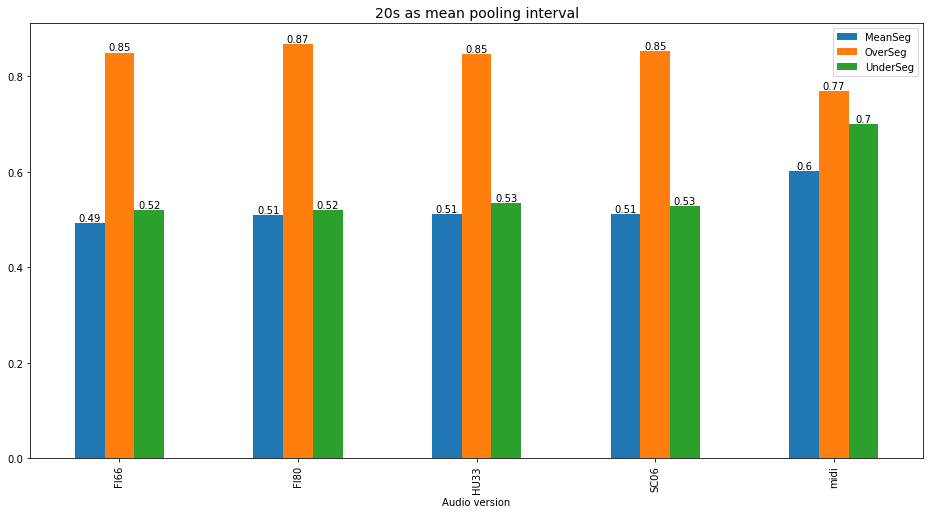

In [177]:
group_by_format_200 = segmentation_eval_without_midi_df_200.groupby("format")
group_by_format_midi_200 = segmentation_eval_midi_df_200.groupby("format")
concat_item_200 = [group_by_format_200.mean(), group_by_format_midi_200.mean()]
result_group_by_format_200 = pd.concat(concat_item_200)

ax_200 = result_group_by_format_200[['MeanSeg', 'OverSeg', 'UnderSeg']].plot(kind='bar', figsize=(16, 8))
ax_200.set_title('20s as mean pooling interval', fontsize = 14)

for bar_plot in ax_200.patches:
    ax_200.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    ax_200.set_xlabel('Audio version')

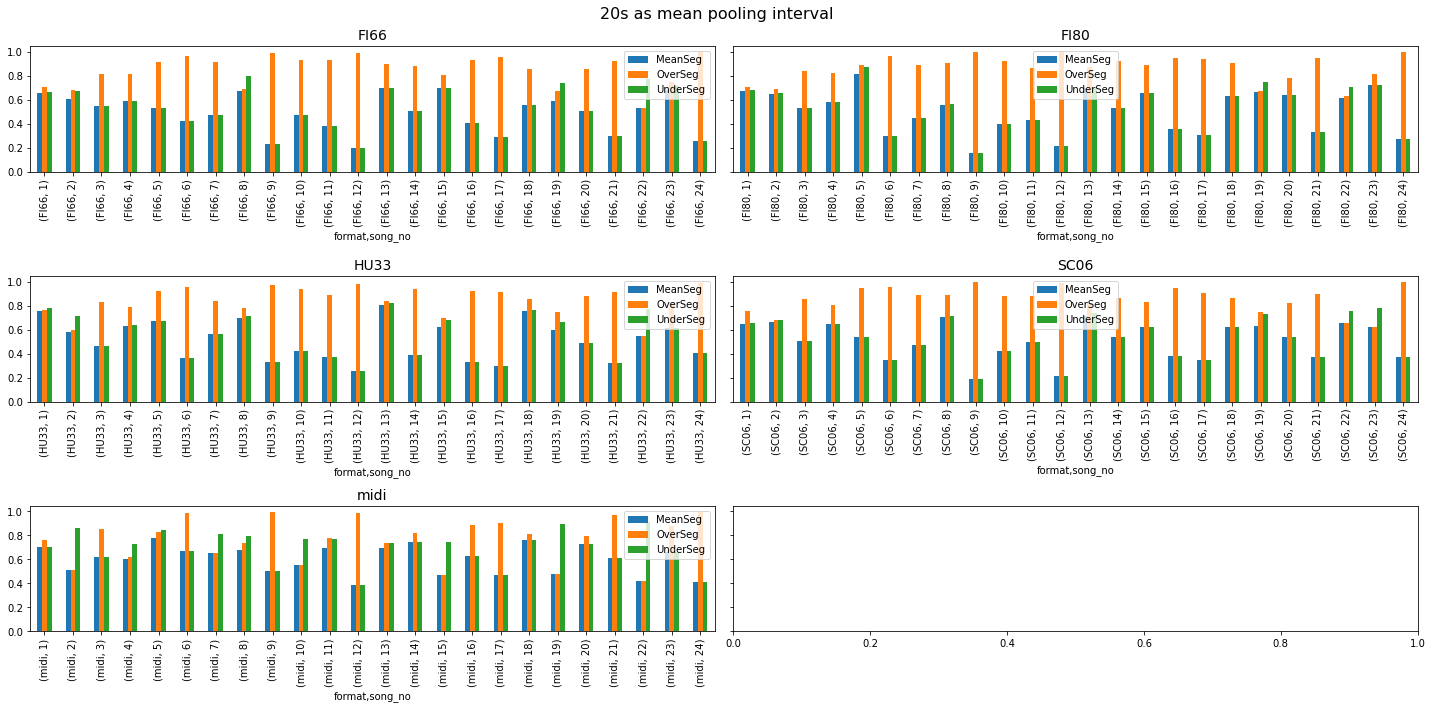

In [178]:
group_by_song_200 = segmentation_eval_without_midi_df_200.groupby(["format", "song_no"])
group_by_song_midi_200 = segmentation_eval_midi_df_200.groupby(["format", "song_no"])
concat_item_song_200 = [group_by_song_200.mean(), group_by_song_midi_200.mean()]
result_group_by_song_200 = pd.concat(concat_item_song_200)

result_group_by_format_200 = result_group_by_song_200.groupby("format")
ncols_200 = 2
nrows_200 = int(np.ceil(result_group_by_format_200.ngroups/ncols_200))

fig_200, axes_200 = plt.subplots(nrows = nrows_200, ncols = ncols_200, figsize = (20,10), sharey = True)
fig_200.suptitle('20s as mean pooling interval', fontsize=16)

for (key, ax_200) in zip(result_group_by_format_200.groups.keys(), axes_200.flatten()):
    ax_200.set_title(key, fontsize = 14)
    result_group_by_format_200.get_group(key).plot(ax = ax_200, kind = 'bar')

ax_200.legend()
fig_200.tight_layout()
plt.show()

In [179]:
segmentation_eval_400 = prediction_eval(400)

[[  0.   29.9]
 [ 29.9  35.6]
 [ 35.6  97.5]
 [ 97.5  97.6]
 [ 97.6  98.2]
 [ 98.2 101.6]
 [101.6 102.4]
 [102.4 102.7]
 [102.7 102.8]
 [102.8 169. ]
 [169.  170.7]
 [170.7 201.6]
 [201.6 201.8]
 [201.8 207. ]
 [207.  220.5]
 [220.5 221.8]
 [221.8 224.7]
 [224.7 235.6]
 [235.6 236.5]
 [236.5 237.3]
 [237.3 309.7]]
[[  1.26  31.68]
 [ 31.68  40.56]
 [ 40.56  49.  ]
 [ 49.    98.92]
 [ 98.92 107.8 ]
 [107.8  116.24]
 [116.24 147.86]
 [147.86 166.52]
 [166.52 175.44]
 [175.44 184.  ]
 [184.   217.16]
 [217.16 239.62]
 [239.62 250.  ]
 [250.   283.28]
 [283.28 305.68]]
[[  0.   20. ]
 [ 20.   29.8]
 [ 29.8  35.5]
 [ 35.5  54.2]
 [ 54.2  54.6]
 [ 54.6  55.6]
 [ 55.6  81.2]
 [ 81.2  97. ]
 [ 97.   97.1]
 [ 97.1  97.7]
 [ 97.7 101.1]
 [101.1 101.9]
 [101.9 102.2]
 [102.2 102.3]
 [102.3 120.5]
 [120.5 120.7]
 [120.7 121.7]
 [121.7 150.9]
 [150.9 168.1]
 [168.1 169.8]
 [169.8 181.1]
 [181.1 309.6]]
[[  1.26  31.68]
 [ 31.68  40.56]
 [ 40.56  49.  ]
 [ 49.    98.92]
 [ 98.92 107.8 ]
 [107.8  116

In [180]:
# --- 40s
segmentation_eval_midi_400 = {"midi":segmentation_eval_400['midi']}
# print(prediction_midi)

segmentation_eval_without_midi_400 = segmentation_eval_400
del segmentation_eval_without_midi_400['midi']

In [181]:
segmentation_eval_without_midi_df_400 = pd.DataFrame.from_dict({(i, j, k, m): segmentation_eval_without_midi_400[i][j][k][m]
                            for i in segmentation_eval_without_midi_400.keys()
                            for j in segmentation_eval_without_midi_400[i].keys()
                            for k in segmentation_eval_without_midi_400[i][j].keys()
                            for m in segmentation_eval_without_midi_400[i][j][k].keys()
                            }, orient='columns').T

segmentation_eval_without_midi_df_400.reset_index(inplace=True)
segmentation_eval_without_midi_df_400.columns = ['format', 'song_no', 'chroma_operation','template_type', 'MeanSeg', 'OverSeg', 'UnderSeg']

In [182]:
segmentation_eval_midi_df_400 = pd.DataFrame.from_dict({(i, j, k): segmentation_eval_midi_400[i][j][k]
                            for i in segmentation_eval_midi_400.keys()
                            for j in segmentation_eval_midi_400[i].keys()
                            for k in segmentation_eval_midi_400[i][j].keys()
                            }, orient='columns').T

segmentation_eval_midi_df_400.reset_index(inplace=True)
segmentation_eval_midi_df_400.columns = ['format', 'song_no','template_type', 'MeanSeg', 'OverSeg', 'UnderSeg']

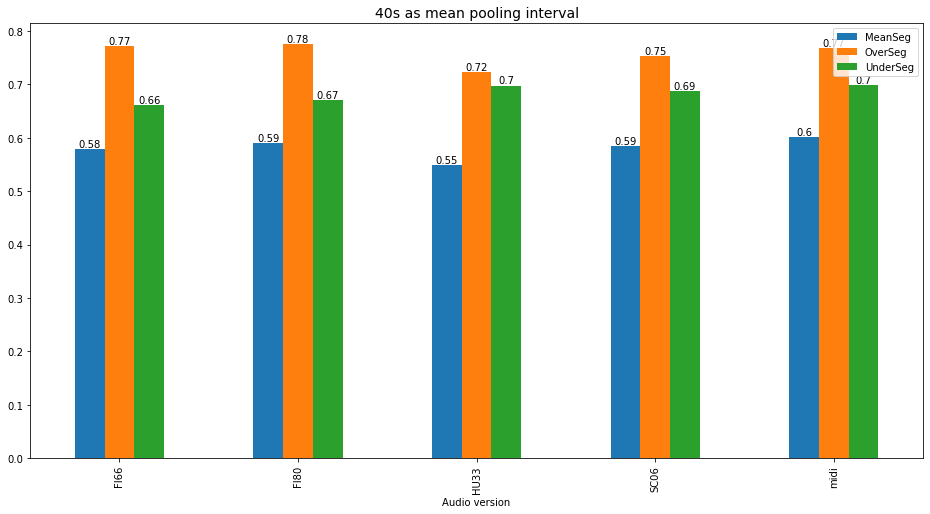

In [183]:
group_by_format_400 = segmentation_eval_without_midi_df_400.groupby("format")
group_by_format_midi_400 = segmentation_eval_midi_df_400.groupby("format")
concat_item_400 = [group_by_format_400.mean(), group_by_format_midi_400.mean()]
result_group_by_format_400 = pd.concat(concat_item_400)

ax_400 = result_group_by_format_400[['MeanSeg', 'OverSeg', 'UnderSeg']].plot(kind='bar', figsize=(16, 8))
ax_400.set_title('40s as mean pooling interval', fontsize = 14)

for bar_plot in ax_400.patches:
    ax_400.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    ax_400.set_xlabel('Audio version')

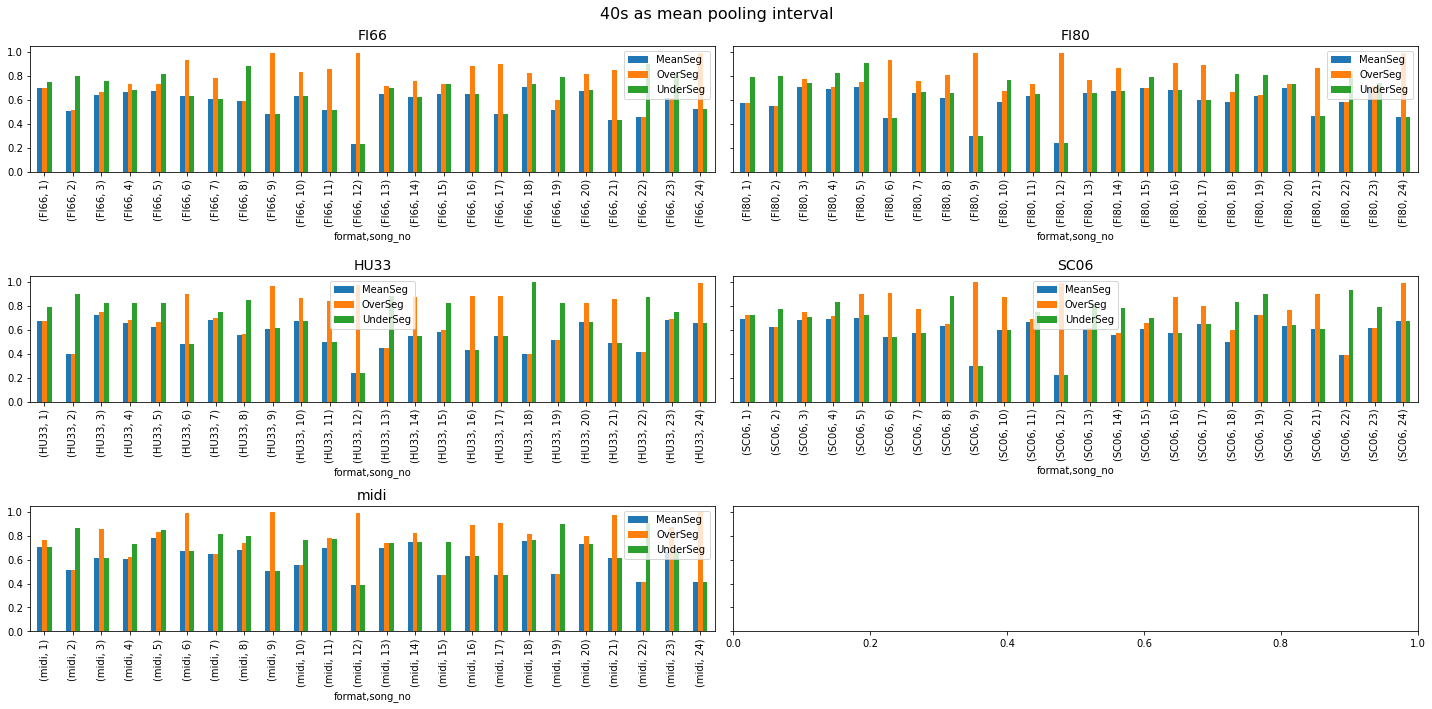

In [184]:
group_by_song_400 = segmentation_eval_without_midi_df_400.groupby(["format", "song_no"])
group_by_song_midi_400 = segmentation_eval_midi_df_400.groupby(["format", "song_no"])
concat_item_song_400 = [group_by_song_400.mean(), group_by_song_midi_400.mean()]
result_group_by_song_400 = pd.concat(concat_item_song_400)

result_group_by_format_400 = result_group_by_song_400.groupby("format")
ncols_400=2
nrows_400 = int(np.ceil(result_group_by_format_400.ngroups/ncols_400))

fig_400, axes_400 = plt.subplots(nrows = nrows_400, ncols = ncols_400, figsize = (20,10), sharey = True)
fig_400.suptitle('40s as mean pooling interval', fontsize=16)

for (key, ax_400) in zip(result_group_by_format_400.groups.keys(), axes_400.flatten()):
    ax_400.set_title(key, fontsize = 14)
    result_group_by_format_400.get_group(key).plot(ax = ax_400, kind = 'bar')

ax_400.legend()
fig_400.tight_layout()
plt.show()

In [185]:
segmentation_eval_500 = prediction_eval(500)

# --- 50s
segmentation_eval_midi_500 = {"midi":segmentation_eval_500['midi']}

segmentation_eval_without_midi_500 = segmentation_eval_500
del segmentation_eval_without_midi_500['midi']

[[  0.  207.8]
 [207.8 208.4]
 [208.4 211.4]
 [211.4 212.1]
 [212.1 212.6]
 [212.6 218.4]
 [218.4 218.5]
 [218.5 219.1]
 [219.1 219.8]
 [219.8 220. ]
 [220.  232.9]
 [232.9 310.6]]
[[  1.26  31.68]
 [ 31.68  40.56]
 [ 40.56  49.  ]
 [ 49.    98.92]
 [ 98.92 107.8 ]
 [107.8  116.24]
 [116.24 147.86]
 [147.86 166.52]
 [166.52 175.44]
 [175.44 184.  ]
 [184.   217.16]
 [217.16 239.62]
 [239.62 250.  ]
 [250.   283.28]
 [283.28 305.68]]
[[  0.   25. ]
 [ 25.   43.7]
 [ 43.7  44.5]
 [ 44.5  46. ]
 [ 46.   77.9]
 [ 77.9 121.7]
 [121.7 147.2]
 [147.2 178.4]
 [178.4 310.9]]
[[  1.26  31.68]
 [ 31.68  40.56]
 [ 40.56  49.  ]
 [ 49.    98.92]
 [ 98.92 107.8 ]
 [107.8  116.24]
 [116.24 147.86]
 [147.86 166.52]
 [166.52 175.44]
 [175.44 184.  ]
 [184.   217.16]
 [217.16 239.62]
 [239.62 250.  ]
 [250.   283.28]
 [283.28 305.68]]
[[  0.  245.2]
 [245.2 245.3]
 [245.3 245.7]
 [245.7 284.4]
 [284.4 288.1]
 [288.1 293. ]
 [293.  296.2]
 [296.2 301.2]
 [301.2 305. ]
 [305.  309.4]
 [309.4 310.3]
 [310.

In [186]:
segmentation_eval_without_midi_df_500 = pd.DataFrame.from_dict({(i, j, k, m): segmentation_eval_without_midi_500[i][j][k][m]
                            for i in segmentation_eval_without_midi_500.keys()
                            for j in segmentation_eval_without_midi_500[i].keys()
                            for k in segmentation_eval_without_midi_500[i][j].keys()
                            for m in segmentation_eval_without_midi_500[i][j][k].keys()
                            }, orient='columns').T

segmentation_eval_without_midi_df_500.reset_index(inplace=True)
segmentation_eval_without_midi_df_500.columns = ['format', 'song_no', 'chroma_operation','template_type', 'MeanSeg', 'OverSeg', 'UnderSeg']

segmentation_eval_midi_df_500 = pd.DataFrame.from_dict({(i, j, k): segmentation_eval_midi_500[i][j][k]
                            for i in segmentation_eval_midi_500.keys()
                            for j in segmentation_eval_midi_500[i].keys()
                            for k in segmentation_eval_midi_500[i][j].keys()
                            }, orient='columns').T

segmentation_eval_midi_df_500.reset_index(inplace=True)
segmentation_eval_midi_df_500.columns = ['format', 'song_no','template_type', 'MeanSeg', 'OverSeg', 'UnderSeg']

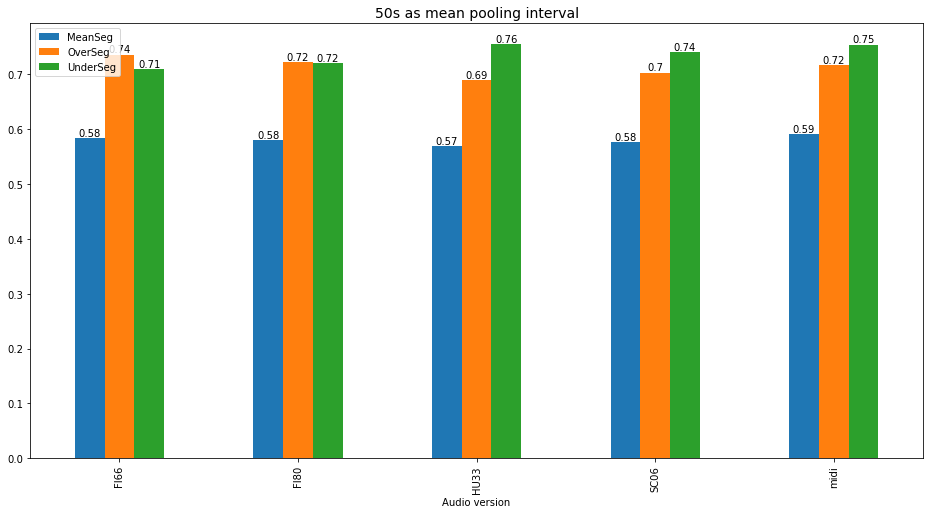

In [189]:
group_by_format_500 = segmentation_eval_without_midi_df_500.groupby("format")
group_by_format_midi_500 = segmentation_eval_midi_df_500.groupby("format")
concat_item_500 = [group_by_format_500.mean(), group_by_format_midi_500.mean()]
result_group_by_format_500 = pd.concat(concat_item_500)

ax_500 = result_group_by_format_500[['MeanSeg', 'OverSeg', 'UnderSeg']].plot(kind='bar', figsize=(16, 8))
ax_500.set_title('50s as mean pooling interval', fontsize = 14)

for bar_plot in ax_500.patches:
    ax_500.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    ax_500.set_xlabel('Audio version')

In [209]:
segmentation_eval_600 = prediction_eval(600)

# --- 50s
segmentation_eval_midi_600 = {"midi":segmentation_eval_600['midi']}

segmentation_eval_without_midi_600 = segmentation_eval_600
del segmentation_eval_without_midi_600['midi']

[[  0.  213.5]
 [213.5 216.3]
 [216.3 229.6]
 [229.6 311.4]]
[[  1.26  31.68]
 [ 31.68  40.56]
 [ 40.56  49.  ]
 [ 49.    98.92]
 [ 98.92 107.8 ]
 [107.8  116.24]
 [116.24 147.86]
 [147.86 166.52]
 [166.52 175.44]
 [175.44 184.  ]
 [184.   217.16]
 [217.16 239.62]
 [239.62 250.  ]
 [250.   283.28]
 [283.28 305.68]]
[[  0.   30. ]
 [ 30.   40.6]
 [ 40.6  73.4]
 [ 73.4 117.5]
 [117.5 143.1]
 [143.1 176.1]
 [176.1 311.1]]
[[  1.26  31.68]
 [ 31.68  40.56]
 [ 40.56  49.  ]
 [ 49.    98.92]
 [ 98.92 107.8 ]
 [107.8  116.24]
 [116.24 147.86]
 [147.86 166.52]
 [166.52 175.44]
 [175.44 184.  ]
 [184.   217.16]
 [217.16 239.62]
 [239.62 250.  ]
 [250.   283.28]
 [283.28 305.68]]
[[  0.  243.8]
 [243.8 244. ]
 [244.  244.6]
 [244.6 283.8]
 [283.8 284.5]
 [284.5 288.1]
 [288.1 291.4]
 [291.4 299.4]
 [299.4 300.3]
 [300.3 307.2]
 [307.2 307.6]
 [307.6 307.8]
 [307.8 310.5]]
[[  1.26  31.68]
 [ 31.68  40.56]
 [ 40.56  49.  ]
 [ 49.    98.92]
 [ 98.92 107.8 ]
 [107.8  116.24]
 [116.24 147.86]
 [147.

In [210]:
segmentation_eval_without_midi_df_600 = pd.DataFrame.from_dict({(i, j, k, m): segmentation_eval_without_midi_600[i][j][k][m]
                            for i in segmentation_eval_without_midi_600.keys()
                            for j in segmentation_eval_without_midi_600[i].keys()
                            for k in segmentation_eval_without_midi_600[i][j].keys()
                            for m in segmentation_eval_without_midi_600[i][j][k].keys()
                            }, orient='columns').T

segmentation_eval_without_midi_df_600.reset_index(inplace=True)
segmentation_eval_without_midi_df_600.columns = ['format', 'song_no', 'chroma_operation','template_type', 'MeanSeg', 'OverSeg', 'UnderSeg']

segmentation_eval_midi_df_600 = pd.DataFrame.from_dict({(i, j, k): segmentation_eval_midi_600[i][j][k]
                            for i in segmentation_eval_midi_600.keys()
                            for j in segmentation_eval_midi_600[i].keys()
                            for k in segmentation_eval_midi_600[i][j].keys()
                            }, orient='columns').T

segmentation_eval_midi_df_600.reset_index(inplace=True)
segmentation_eval_midi_df_600.columns = ['format', 'song_no','template_type', 'MeanSeg', 'OverSeg', 'UnderSeg']

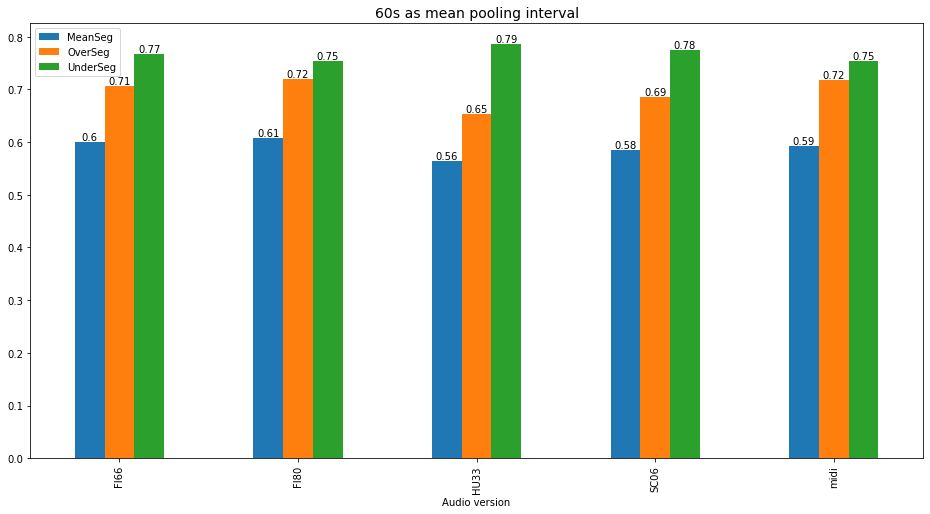

In [212]:
group_by_format_600 = segmentation_eval_without_midi_df_600.groupby("format")
group_by_format_midi_600 = segmentation_eval_midi_df_600.groupby("format")
concat_item_600 = [group_by_format_600.mean(), group_by_format_midi_600.mean()]
result_group_by_format_600 = pd.concat(concat_item_600)

ax_600 = result_group_by_format_600[['MeanSeg', 'OverSeg', 'UnderSeg']].plot(kind='bar', figsize=(16, 8))
ax_600.set_title('60s as mean pooling interval', fontsize = 14)

for bar_plot in ax_600.patches:
    ax_600.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    ax_600.set_xlabel('Audio version')

In [ ]:
segmentation_eval_100 = prediction_eval(100)

# --- 50s
segmentation_eval_midi_100 = {"midi":segmentation_eval_100['midi']}

segmentation_eval_without_midi_100 = segmentation_eval_100
del segmentation_eval_without_midi_100['midi']

In [ ]:
segmentation_eval_without_midi_df_100 = pd.DataFrame.from_dict({(i, j, k, m): segmentation_eval_without_midi_100[i][j][k][m]
                            for i in segmentation_eval_without_midi_100.keys()
                            for j in segmentation_eval_without_midi_100[i].keys()
                            for k in segmentation_eval_without_midi_100[i][j].keys()
                            for m in segmentation_eval_without_midi_100[i][j][k].keys()
                            }, orient='columns').T

segmentation_eval_without_midi_df_100.reset_index(inplace=True)
segmentation_eval_without_midi_df_100.columns = ['format', 'song_no', 'chroma_operation','template_type', 'MeanSeg', 'OverSeg', 'UnderSeg']

segmentation_eval_midi_df_100 = pd.DataFrame.from_dict({(i, j, k): segmentation_eval_midi_100[i][j][k]
                            for i in segmentation_eval_midi_100.keys()
                            for j in segmentation_eval_midi_100[i].keys()
                            for k in segmentation_eval_midi_100[i][j].keys()
                            }, orient='columns').T

segmentation_eval_midi_df_100.reset_index(inplace=True)
segmentation_eval_midi_df_100.columns = ['format', 'song_no','template_type', 'MeanSeg', 'OverSeg', 'UnderSeg']

In [ ]:
group_by_format_100 = segmentation_eval_without_midi_df_100.groupby("format")
group_by_format_midi_100 = segmentation_eval_midi_df_100.groupby("format")
concat_item_100 = [group_by_format_100.mean(), group_by_format_midi_100.mean()]
result_group_by_format_100 = pd.concat(concat_item_100)

ax_100 = result_group_by_format_100[['MeanSeg', 'OverSeg', 'UnderSeg']].plot(kind='bar', figsize=(16, 8))
ax_100.set_title('10s as mean pooling interval', fontsize = 14)

for bar_plot in ax_100.patches:
    ax_100.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    ax_100.set_xlabel('Audio version')

In [190]:
# 沿用 Q4 tempo estimation
tempo_dict = {'HU33': {1: 117.45383523 , # 20s best
  2: 112.34714674 ,  # 30s best
  3: 103.359375 , # 40s best
  4: 123.046875 , # 2, 3, 40s
  5: 123.046875 , # 30s
  6: 123.046875 , # 50s
  7: 117.45383523 , # 40s
  8: 123.046875 , # 20s
  9: 117.45383523 , # 50s
  10: 129.19921875 , # 50s
  11: 123.046875 , # 50s
  12: 117.45383523 , # 50s
  13: 112.34714674 , # 20s
  14: 123.046875 , # 50s
  15: 129.19921875 , # 30s
  16: 129.19921875 , # 50s
  17: 123.046875 , # 50s
  18: 112.34714674 , # 20s
  19: 117.45383523 , # 20s
  20: 129.19921875 , # 50s
  21: 129.19921875 , # 50s
  22: 107.66601562 , # 20s
  23: 123.046875 , # 30s
  24: 117.45383523}, # 50s
 'SC06': {1: 107.66601562 , # 30s best
  2: 117.45383523 , # 20s best
  3: 103.359375 , # 40s best
  4: 123.046875 ,
  5: 123.046875 ,
  6: 135.99917763 ,
  7: 103.359375 ,
  8: 129.19921875 ,
  9: 107.66601562 ,
  10: 103.359375 ,
  11: 123.046875 ,
  12: 129.19921875 ,
  13: 103.359375 ,
  14: 123.046875 ,
  15: 143.5546875 ,
  16: 103.359375 ,
  17: 107.66601562 ,
  18: 112.34714674 ,
  19: 117.45383523 ,
  20: 99.38401442 ,
  21: 123.046875 ,
  22: 112.34714674 ,
  23: 123.046875 ,
  24: 123.046875},
 'FI66': {1: 99.38401442 , # 40s best
  2: 103.359375 , # 20s best
  3: 89.10290948 ,  # 30s best
  4: 143.5546875 ,
  5: 135.99917763 ,
  6: 117.45383523 ,
  7: 135.99917763 ,
  8: 117.45383523 ,
  9: 117.45383523 ,
  10: 95.703125 ,
  11: 129.19921875 ,
  12: 135.99917763 ,
  13: 143.5546875 ,
  14: 123.046875 ,
  15: 135.99917763 ,
  16: 107.66601562 ,
  17: 112.34714674 ,
  18: 99.38401442 ,
  19: 103.359375 ,
  20: 89.10290948 ,
  21: 123.046875 ,
  22: 95.703125 ,
  23: 117.45383523 ,
  24: 135.99917763},
 'FI80': {1: 107.66601562 , # 20s best
  2: 103.359375 , # 20s best
  3: 103.359375 , # 40s best
  4: 129.19921875 ,
  5: 123.046875 ,
  6: 123.046875 ,
  7: 95.703125 ,
  8: 117.45383523 ,
  9: 112.34714674 ,
  10: 99.38401442 ,
  11: 135.99917763 ,
  12: 135.99917763 ,
  13: 99.38401442 ,
  14: 129.19921875 ,
  15: 117.45383523 ,
  16: 112.34714674 ,
  17: 129.19921875 ,
  18: 95.703125 ,
  19: 99.38401442 ,
  20: 123.046875 ,
  21: 117.45383523 ,
  22: 95.703125 ,
  23: 129.19921875 ,
  24: 117.45383523},
 'midi': {1: 135.38462666666766, # 50s best
  2: 192.66791544019222, # 20s best
  3: 60.0,  # 50s best
  4: 269.62127169781354, # 20s best, all similar
  5: 233.34799394770707, # 20s best, not 50s
  6: 184.09090909090708, # 50s best, top
  7: 183.61204013377898, # 30s best, not 50s
  8: 199.99999999999957, # 20s best, not 50s
  9: 194.33198380566765, # 20s best, all similar
  10: 200.43405400950516, # 20s best, not 50s
  11: 190.5796422886037,  # 20s best, not 50s
  12: 173.51828499369526, # 40s best, all similar
  13: 184.51178451178447, # 30s best, not 50s
  14: 111.82914990985988, # 50s
  15: 179.99378474500185, # 50s
  16: 188.52081584008238, # 50s
  17: 174.18377130132674, # 50s
  18: 190.95248920209113, # 20s
  19: 182.89112959434942, # 30s, all similar, not 50s
  20: 110.7692584615446, # 50s
  21: 113.86399578281492, # 50s
  22: 167.74193548387098, # 20s
  23: 118.77819306611671, # 50s
  24: 182.4561403508774}} # 30s, all similar
# 190--20s
# 180--30s
# 170--40s
# 以下--50s

In [200]:
temp_dict_df = pd.DataFrame.from_dict({(i): tempo_dict[i]
                            for i in tempo_dict.keys()
                            }, orient='columns')
temp_dict_df['midi']

1     135.384627
2     192.667915
3      60.000000
4     269.621272
5     233.347994
6     184.090909
7     183.612040
8     200.000000
9     194.331984
10    200.434054
11    190.579642
12    173.518285
13    184.511785
14    111.829150
15    179.993785
16    188.520816
17    174.183771
18    190.952489
19    182.891130
20    110.769258
21    113.863996
22    167.741935
23    118.778193
24    182.456140
Name: midi, dtype: float64

In [201]:
# 以較穩定的 midi 檔案作為標準建立 mean_pool_range_list
# 190--20s
# 180--30s
# 170--40s
# 以下--50s
mean_pool_range_list = []
for tempo in temp_dict_df['midi']:
    if tempo >= 190:
        mean_pool_range_list.append(200)
    elif tempo >= 180:
        mean_pool_range_list.append(300)
    elif tempo >= 170:
        mean_pool_range_list.append(400)
    elif tempo < 170:
        mean_pool_range_list.append(500)

mean_pool_range_list

[500,
 200,
 500,
 200,
 200,
 300,
 300,
 200,
 200,
 200,
 200,
 400,
 300,
 500,
 400,
 300,
 400,
 200,
 300,
 500,
 500,
 500,
 500,
 300]

In [202]:
def prediction_eval_tempo(mean_pool_range_list:list):
    segmentation_eval = {}

    analysis_path = "./temp/SWD_analysis_Q5/"
    try:
        shutil.rmtree(analysis_path)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))

    for format in file_type:
        segmentation_eval[format] = {}
        if format == 'midi':
            for song_no in range(1, 25):
                segmentation_eval[format][song_no] = {}
                for template_type in template_types:
                    prediction_save_path = "./temp/SWD_analysis_Q4/" + format + "/" + str(mean_pool_range_list[song_no-1]) + "/" + str(song_no) + "/" + template_type + ".txt"
                    segmentation_eval[format][song_no][template_type] = {}
                    prediction_time_output = "./temp/SWD_analysis_Q5/" + format + "/" + str(mean_pool_range_list[song_no-1]) + "/" + str(song_no) + "/" + template_type + ".csv"
                    
                    os.makedirs(os.path.dirname(prediction_time_output), exist_ok=True)
                    with open(prediction_time_output, 'w') as output_file:
                        output_writer = csv.writer(output_file, delimiter = ';', quotechar = "'", quoting = csv.QUOTE_MINIMAL)
                        output_writer.writerow(['start','end','key'])
                    
                    with open(prediction_save_path) as file_p:
                        lines = file_p.readlines()
                        count = 0
                        base_time = 0.0
                        prev_frame_key = 0
                        for line in lines:
                            if count == 0:
                                prev_frame_key = int(line.strip())
                                count += 1
                            else: 
                                frame_key = int(line.strip())
                                if frame_key == prev_frame_key:
                                    count += 1
                                else:
                                    with open(prediction_time_output, 'a') as output_file:
                                        output_writer = csv.writer(output_file, delimiter = ';', quotechar = "'", quoting = csv.QUOTE_MINIMAL)
                                        output_label = annotation_scale[frame_key]
                                        if frame_key < 12:
                                            output_label = output_label + ':maj'
                                        else:
                                            output_label = output_label + ':min'
                                        output_writer.writerow([round(base_time, 2), round(base_time + (count * 0.1), 2), '\"' + output_label + '\"'])
                                    prev_frame_key = frame_key
                                    base_time += count * 0.1
                                    count = 0
                        if count != 0:
                            with open(prediction_time_output, 'a') as output_file:
                                output_writer = csv.writer(output_file, delimiter = ';', quotechar = "'", quoting = csv.QUOTE_MINIMAL)
                                output_label = annotation_scale[frame_key]
                                if frame_key < 12:
                                    output_label = output_label + ':maj'
                                else:
                                    output_label = output_label + ':min'
                                output_writer.writerow([round(base_time, 2), round(base_time + (count * 0.1), 2), '\"' + output_label + '\"'])

                    intervals_prediction, labels_prediction = mir_eval.io.load_labeled_intervals(prediction_time_output, 
                                                                                    delimiter=';',
                                                                                    comment='start;end;key')
                    print(intervals_prediction)
                    intervals_answer, labels_answer = mir_eval.io.load_labeled_intervals('./HW1 Datasets/SWD/SWD/02_Annotations/ann_audio_localkey-ann1/Schubert_D911-' + str(song_no).zfill(2) + '_HU33.csv', 
                                                                                    delimiter=';',
                                                                                    comment='start;end;key')    
                    print(intervals_answer)
                    # Compute the MIREX ‘MeanSeg’ score.
                    #   Comparison score, in [0.0, 1.0], where 1.0 means perfect segmentation.
                    segmentation_eval[format][song_no][template_type]['MeanSeg'] = mir_eval.chord.seg(intervals_prediction, intervals_answer)
                    # Computes the level of over-segmentation
                    # over-segmentation score
                    #   Comparison score, in [0.0, 1.0], where 1.0 means no oversegmentation.
                    segmentation_eval[format][song_no][template_type]['OverSeg'] = mir_eval.chord.overseg(intervals_prediction, intervals_answer)
                    # Computes the level of under-segmentation
                    segmentation_eval[format][song_no][template_type]['UnderSeg'] = mir_eval.chord.underseg(intervals_prediction, intervals_answer) 
                    

        else:
            for song_no in range(1, 25):
                segmentation_eval[format][song_no] = {}
                for chroma_operation in chroma_operations:
                    segmentation_eval[format][song_no][chroma_operation] = {}
                    for template_type in template_types:
                        prediction_save_path = "./temp/SWD_analysis_Q4/" + format + "/" + str(mean_pool_range_list[song_no-1]) + "/" + str(song_no) + "/" + chroma_operation + "/" + template_type + ".txt"
                        segmentation_eval[format][song_no][chroma_operation][template_type] = {}
                        prediction_time_output = "./temp/SWD_analysis_Q5/" + format + "/" + str(mean_pool_range_list[song_no-1]) + "/" + str(song_no) + "/" + chroma_operation + "/" + template_type + ".csv"
                        
                        os.makedirs(os.path.dirname(prediction_time_output), exist_ok=True)
                        with open(prediction_time_output, 'w') as output_file:
                            output_writer = csv.writer(output_file, delimiter = ';', quotechar = "'", quoting = csv.QUOTE_MINIMAL)
                            output_writer.writerow(['start','end','key'])

                        with open(prediction_save_path) as file_p:
                            lines = file_p.readlines()
                            count = 0
                            base_time = 0.0
                            prev_frame_key = 0
                            for line in lines:
                                if count == 0:
                                    prev_frame_key = int(line.strip())
                                    count += 1
                                else: 
                                    frame_key = int(line.strip())
                                    if frame_key == prev_frame_key:
                                        count += 1
                                    else:
                                        with open(prediction_time_output, 'a') as output_file:
                                            output_writer = csv.writer(output_file, delimiter = ';', quotechar = "'", quoting = csv.QUOTE_MINIMAL)
                                            output_label = annotation_scale[frame_key]
                                            if frame_key < 12:
                                                output_label = output_label + ':maj'
                                            else:
                                                output_label = output_label + ':min'
                                            output_writer.writerow([round(base_time, 2), round(base_time + (count * 0.1), 2), '\"' + output_label + '\"'])
                                        prev_frame_key = frame_key
                                        base_time += count * 0.1
                                        count = 0
                            if count != 0:
                                with open(prediction_time_output, 'a') as output_file:
                                    output_writer = csv.writer(output_file, delimiter = ';', quotechar = "'", quoting = csv.QUOTE_MINIMAL)
                                    output_label = annotation_scale[frame_key]
                                    if frame_key < 12:
                                        output_label = output_label + ':maj'
                                    else:
                                        output_label = output_label + ':min'
                                    output_writer.writerow([round(base_time, 2), round(base_time + (count * 0.1), 2), '\"' + output_label + '\"'])

                        intervals_prediction, labels_prediction = mir_eval.io.load_labeled_intervals(prediction_time_output, 
                                                                                        delimiter=';',
                                                                                        comment='start;end;key')
                        print(intervals_prediction)
                        intervals_answer, labels_answer = mir_eval.io.load_labeled_intervals('./HW1 Datasets/SWD/SWD/02_Annotations/ann_audio_localkey-ann1/Schubert_D911-' + str(song_no).zfill(2) + '_' + format +'.csv', 
                                                                                        delimiter=';',
                                                                                        comment='start;end;key')    
                        print(intervals_answer)
                        # Compute the MIREX ‘MeanSeg’ score.
                        #   Comparison score, in [0.0, 1.0], where 1.0 means perfect segmentation.
                        segmentation_eval[format][song_no][chroma_operation][template_type]['MeanSeg'] = mir_eval.chord.seg(intervals_prediction, intervals_answer)
                        # Computes the level of over-segmentation
                        # over-segmentation score
                        #   Comparison score, in [0.0, 1.0], where 1.0 means no oversegmentation.
                        segmentation_eval[format][song_no][chroma_operation][template_type]['OverSeg'] = mir_eval.chord.overseg(intervals_prediction, intervals_answer)
                        # Computes the level of under-segmentation
                        #    Comparison score, in [0.0, 1.0], where 1.0 means no undersegmentation.
                        segmentation_eval[format][song_no][chroma_operation][template_type]['UnderSeg'] = mir_eval.chord.underseg(intervals_prediction, intervals_answer)
    return segmentation_eval

In [203]:
segmentation_eval_optimize = prediction_eval_tempo(mean_pool_range_list)

[[  0.  207.8]
 [207.8 208.4]
 [208.4 211.4]
 [211.4 212.1]
 [212.1 212.6]
 [212.6 218.4]
 [218.4 218.5]
 [218.5 219.1]
 [219.1 219.8]
 [219.8 220. ]
 [220.  232.9]
 [232.9 310.6]]
[[  1.26  31.68]
 [ 31.68  40.56]
 [ 40.56  49.  ]
 [ 49.    98.92]
 [ 98.92 107.8 ]
 [107.8  116.24]
 [116.24 147.86]
 [147.86 166.52]
 [166.52 175.44]
 [175.44 184.  ]
 [184.   217.16]
 [217.16 239.62]
 [239.62 250.  ]
 [250.   283.28]
 [283.28 305.68]]
[[  0.   25. ]
 [ 25.   43.7]
 [ 43.7  44.5]
 [ 44.5  46. ]
 [ 46.   77.9]
 [ 77.9 121.7]
 [121.7 147.2]
 [147.2 178.4]
 [178.4 310.9]]
[[  1.26  31.68]
 [ 31.68  40.56]
 [ 40.56  49.  ]
 [ 49.    98.92]
 [ 98.92 107.8 ]
 [107.8  116.24]
 [116.24 147.86]
 [147.86 166.52]
 [166.52 175.44]
 [175.44 184.  ]
 [184.   217.16]
 [217.16 239.62]
 [239.62 250.  ]
 [250.   283.28]
 [283.28 305.68]]
[[  0.  245.2]
 [245.2 245.3]
 [245.3 245.7]
 [245.7 284.4]
 [284.4 288.1]
 [288.1 293. ]
 [293.  296.2]
 [296.2 301.2]
 [301.2 305. ]
 [305.  309.4]
 [309.4 310.3]
 [310.

In [204]:
# --- test
segmentation_eval_optimize_midi = {"midi":segmentation_eval_optimize['midi']}

segmentation_eval_optimize_without_midi = segmentation_eval_optimize
del segmentation_eval_optimize_without_midi['midi']

In [ ]:
segmentation_eval_optimize_without_midi = pd.DataFrame.from_dict({(i, j, k, m): segmentation_eval_optimize_without_midi[i][j][k][m]
                            for i in segmentation_eval_optimize_without_midi.keys()
                            for j in segmentation_eval_optimize_without_midi[i].keys()
                            for k in segmentation_eval_optimize_without_midi[i][j].keys()
                            for m in segmentation_eval_optimize_without_midi[i][j][k].keys()
                            }, orient='columns').T

segmentation_eval_optimize_without_midi.reset_index(inplace=True)
segmentation_eval_optimize_without_midi.columns = ['format', 'song_no', 'chroma_operation','template_type', 'MeanSeg', 'OverSeg', 'UnderSeg']

segmentation_eval_optimize_midi = pd.DataFrame.from_dict({(i, j, k): segmentation_eval_optimize_midi[i][j][k]
                            for i in segmentation_eval_optimize_midi.keys()
                            for j in segmentation_eval_optimize_midi[i].keys()
                            for k in segmentation_eval_optimize_midi[i][j].keys()
                            }, orient='columns').T

segmentation_eval_optimize_midi.reset_index(inplace=True)
segmentation_eval_optimize_midi.columns = ['format', 'song_no','template_type', 'MeanSeg', 'OverSeg', 'UnderSeg']
group_by_format_optimize = segmentation_eval_optimize_without_midi.groupby("format")
group_by_format_midi_optimize = segmentation_eval_optimize_midi.groupby("format")
concat_item_optimize = [group_by_format_optimize.mean(), group_by_format_midi_optimize.mean()]
result_group_by_format_optimize = pd.concat(concat_item_optimize)

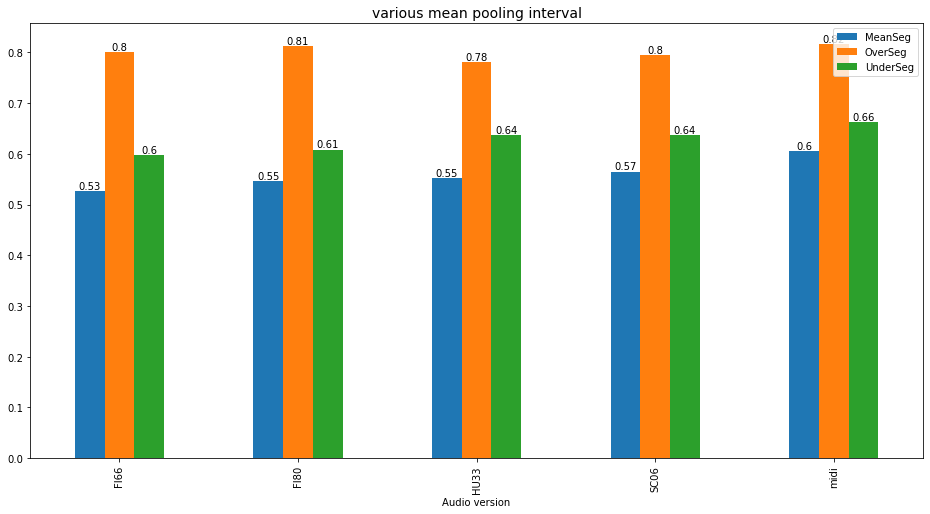

In [207]:
ax_optimize = result_group_by_format_optimize[['MeanSeg', 'OverSeg', 'UnderSeg']].plot(kind='bar', figsize=(16, 8))
ax_optimize.set_title('various mean pooling interval', fontsize = 14)

for bar_plot in ax_optimize.patches:
    ax_optimize.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    ax_optimize.set_xlabel('Audio version')